Overview
Welcome to the 2024 Kaggle Playground Series! Happy New Year! This is the 1st episode of Season 4. We plan to continue in the spirit of previous playgrounds, providing interesting an approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: For this Episode of the Series, your task is to predict whether a customer continues with their account or closes it (e.g., churns). Good luck!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("data/train.csv")
target = 'Exited'
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
df.isnull().any()

id                 False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [4]:
df.duplicated().sum()

0

In [5]:
drop_cols = ['id','CustomerId','Surname']
df = df.drop(drop_cols, axis = 1)

In [6]:
mapping = {
    0: 'No',
    1: 'Yes'
}

df['IsActiveMember'] = df['IsActiveMember'].map(mapping)
df['HasCrCard'] = df['HasCrCard'].map(mapping)
df['Exited'] = df['Exited'].map(mapping)

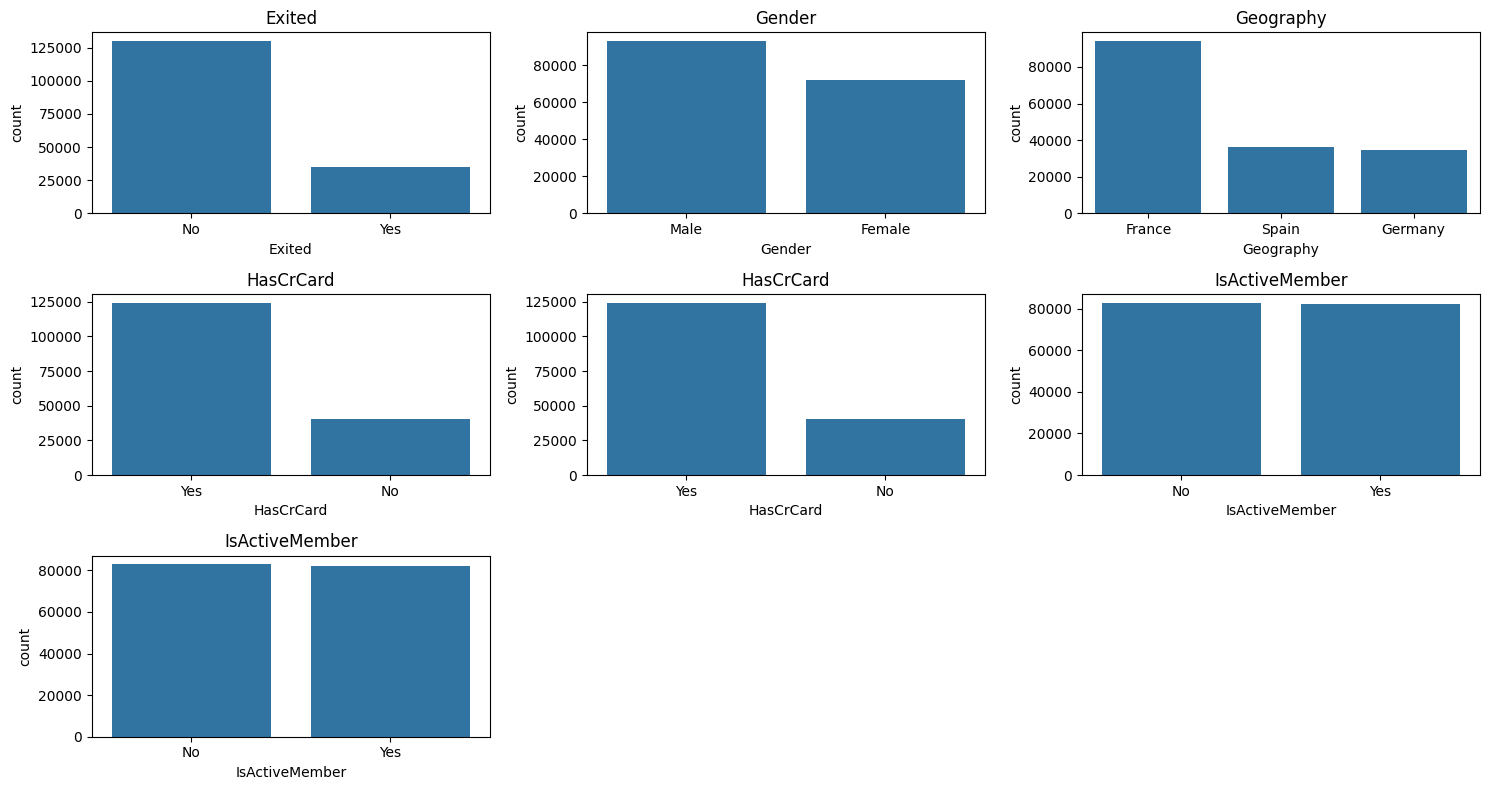

In [7]:
binary_cols = ['IsActiveMember','HasCrCard']
cat_cols = sorted(list(df.select_dtypes(include = 'object').columns) + binary_cols)
plt.figure(figsize = (15, 8))

i = 1
for col in cat_cols:
    plt.subplot(3, 3, i)
    sns.countplot(data = df, x = col)
    plt.title(col)
    i += 1
plt.tight_layout()
cat_cols = [c for c in cat_cols if c != target]

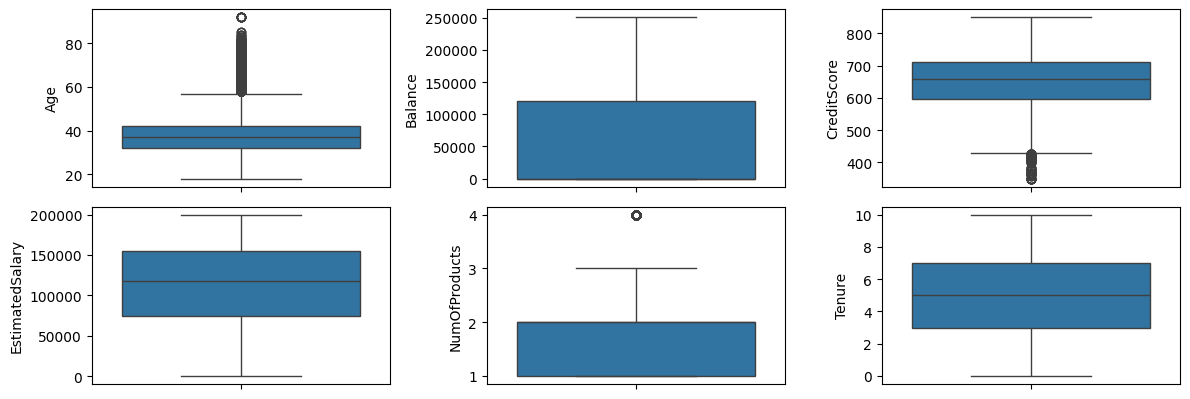

In [8]:
plt.figure(figsize = (12, 8))
num_cols = df.select_dtypes(exclude = 'object').columns
num_cols = sorted([c for c in num_cols if c not in binary_cols])

i = 1
for col in num_cols:
    plt.subplot(4, 3, i)
    sns.boxplot(data = df, y = col)
    i += 1

plt.tight_layout()

In [9]:
reverse_map = {
    'No': 0,
    'Yes': 1
}
df['Exited'] = df['Exited'].map(reverse_map)

<Axes: >

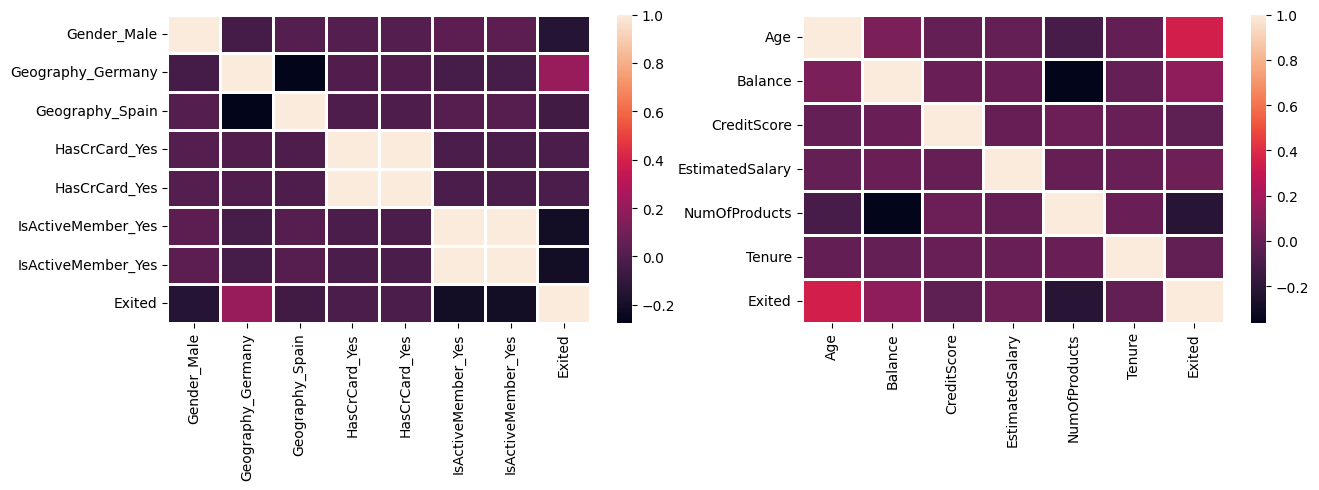

In [10]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
sns.heatmap(pd.concat([pd.get_dummies(df[cat_cols], dtype = int, drop_first = True), df['Exited']], axis = 1).corr(), linewidth = 1)

plt.subplot(1, 2, 2)
sns.heatmap(pd.concat([pd.get_dummies(df[num_cols], dtype = int, drop_first = True), df['Exited']], axis = 1).corr(), linewidth = 1)

<Axes: >

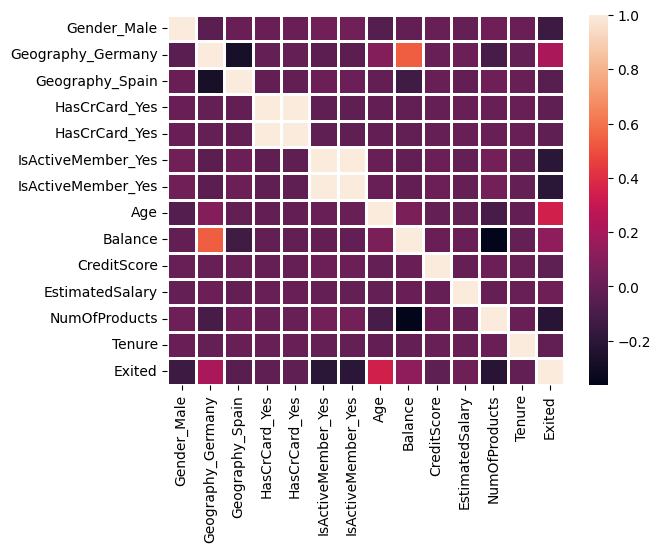

In [11]:
sns.heatmap(pd.concat([pd.get_dummies(df[cat_cols], drop_first = True), df[num_cols], df['Exited']], axis = 1).corr(), linewidth = 1)

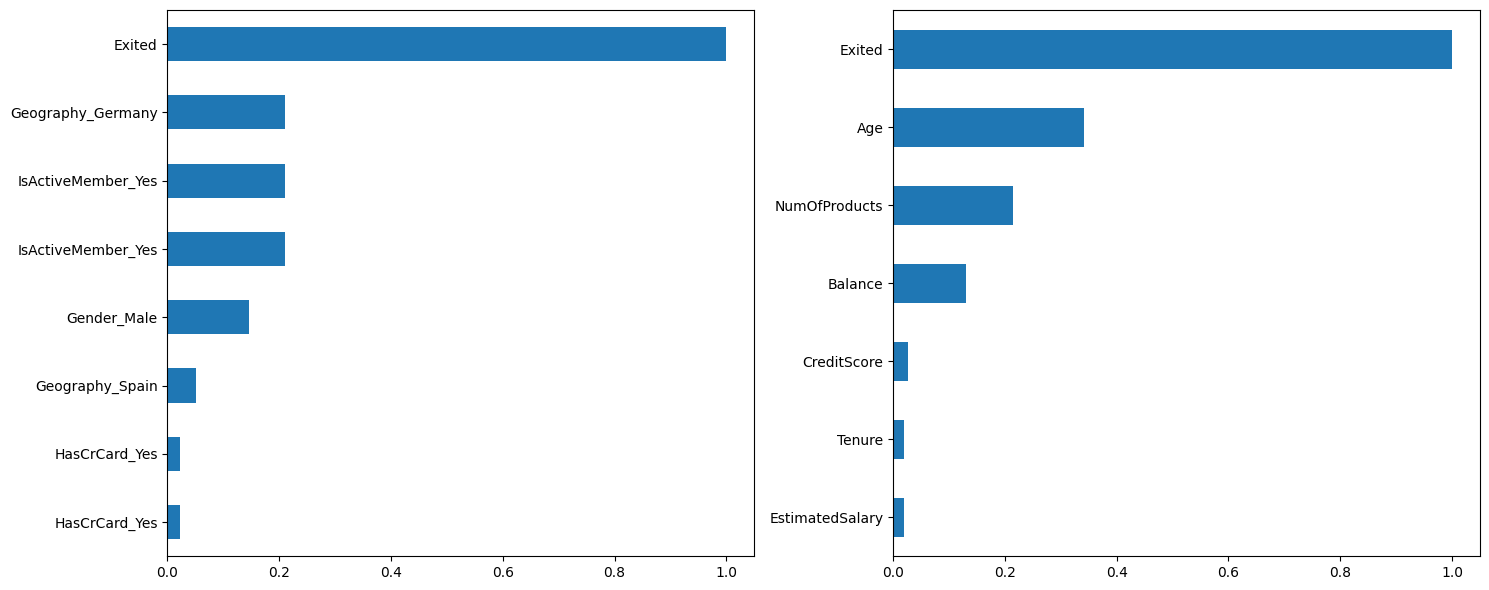

In [14]:
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
np.abs(pd.concat([pd.get_dummies(df[cat_cols], dtype = int, drop_first = True), df['Exited']], axis = 1).corr()['Exited']).sort_values(ascending = True).plot(kind = 'barh')

plt.subplot(1, 2, 2)
np.abs(pd.concat([pd.get_dummies(df[num_cols], dtype = int, drop_first = True), df['Exited']], axis = 1).corr()['Exited']).sort_values().plot(kind = 'barh')

plt.tight_layout()

In [13]:
X = df.drop(target, axis = 1)
y = df[target]

In [18]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

In [20]:
preproc_num = make_pipeline(
    RobustScaler()
)

preproc_cat = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

preproc_transformer = make_column_transformer(
    (preproc_num, num_cols),
    (preproc_cat, cat_cols),
    remainder='passthrough'
)

preproc_selector = SelectPercentile(mutual_info_classif, percentile = 50)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'Balance',
                                                   'CreditScore',
                                                   'EstimatedSalary',
                                                   'NumOfProducts', 'Tenure']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Geography',
                                                   'HasCrCard', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'IsActiveMember'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_classif at 0x12af204c0>))])

# Build Model

In [80]:
xgb_params_optuna = {'max_depth': 5,
                     'min_child_weight': 2, 
                     'learning_rate': 0.07353564842520434,
                     'n_estimators': 463, 
                     'subsample': 0.8131149969184862,
                     'colsample_bytree': 0.6598001508811656,
                     'random_state': 42}

model = XGBClassifier(**xgb_params_optuna)
pipe_model = make_pipeline(preproc, model)

In [81]:
pipe_model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('robustscaler',
                                                                                    RobustScaler())]),
                                                                   ['Age',
                                                                    'Balance',
                                                                    'CreditScore',
                                                                    'EstimatedSalary',
                                                                    'NumOfProducts',
                                                                    'Tenure']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07353564842520434, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=463, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [87]:
y_pred = pipe_model.predict(X_test)
y_pred_proba = pipe_model.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.2608737 , 0.0117696 , 0.02675745, ..., 0.3265301 , 0.04470183,
       0.02381286], dtype=float32)

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     26019
           1       0.75      0.52      0.62      6988

    accuracy                           0.86     33007
   macro avg       0.81      0.74      0.77     33007
weighted avg       0.85      0.86      0.85     33007



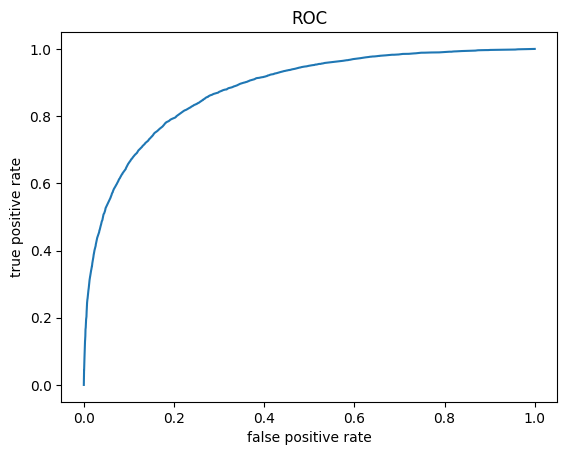

In [93]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.title("ROC")
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
plt.plot(fpr, tpr);

In [94]:
test_df = pd.read_csv("data/test.csv")

In [95]:
ids = test_df['id']

In [96]:
test_df = test_df.drop(drop_cols, axis = 1)
test_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00
...,...,...,...,...,...,...,...,...,...,...
110018,570,Spain,Male,29.0,7,116099.82,1,1.0,1.0,148087.62
110019,575,France,Female,36.0,4,178032.53,1,1.0,1.0,42181.68
110020,712,France,Male,31.0,2,0.00,2,1.0,0.0,16287.38
110021,709,France,Female,32.0,3,0.00,1,1.0,1.0,158816.58


In [97]:
test_df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [98]:
test_df['HasCrCard'] = test_df['HasCrCard'].astype(str)
test_df['IsActiveMember'] = test_df['IsActiveMember'].astype(str)

In [100]:
y_pred = pipe_model.predict(test_df)
y_pred_proba = pipe_model.predict_proba(test_df)[:, 1]
y_pred_proba

array([0.03805979, 0.58476096, 0.0171412 , ..., 0.01342133, 0.11838035,
       0.19966216], dtype=float32)

In [101]:
submission = pd.read_csv("data/sample_submission.csv")

In [102]:
submission['Exited'] = y_pred_proba

In [103]:
submission.to_csv("submission.csv", index = False)